In [2]:
!pip install torchsummary

### Import Libraries

In [322]:
import torch
from torchvision.datasets import ImageFolder
from  torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.models import resnet18, resnet50, efficientnet_b0, vgg16
from torchmetrics import Accuracy
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

In [323]:
categories = [
    "adenocarcinoma",
    "large.cell.carcinoma",
    "normal",
    "squamous.cell.carcinoma"
    ]

### Define transformer

In [324]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224, padding=4),
    ])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224), antialias=True),
    ])

In [325]:
train_data = ImageFolder("/kaggle/input/chest-ct-images/Data/train", transform=train_transform)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
batch = next(iter(train_dataloader))
images, labels = batch
print(f"Feature batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


### Plot one batch of samples

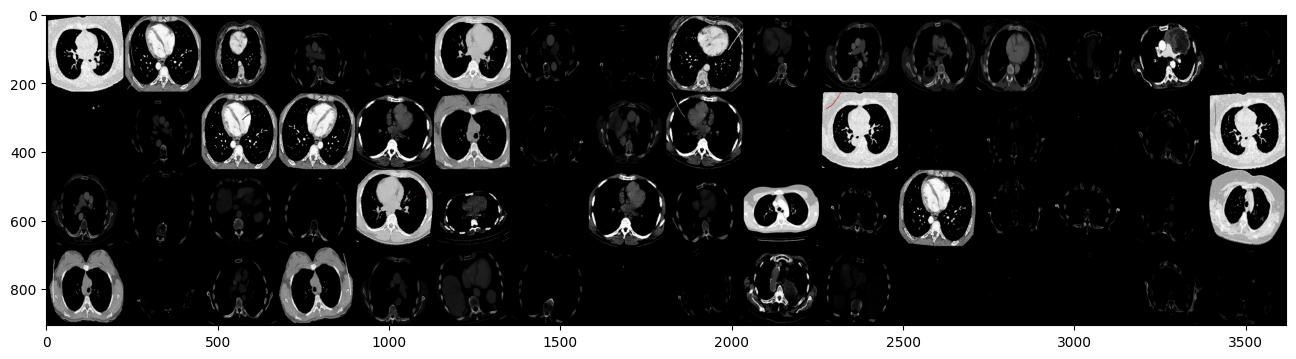

In [326]:
plt.figure(figsize=(16, 8))
out = make_grid(images, nrow=16).permute(1, 2, 0)
plt.imshow(out)
plt.show()

### Make a model from scratch

In [327]:
batch_size = 64
learning_rate = 0.01
num_epochs = 10

In [330]:
class ClassificationModel(pl.LightningModule):

  def __init__(self):
    super(ClassificationModel, self).__init__()

    self.train_acc_plot = []
    self.train_loss_plot = []
    self.val_acc_plot = []
    self.val_loss_plot = []
    self.train_loss_outputs = []
    self.train_acc_outputs = []
    self.val_loss_outputs = []
    self.val_acc_outputs = []

    self.train_acc = Accuracy(task="multiclass", num_classes=4)
    self.val_acc = Accuracy(task="multiclass", num_classes=4)

    self.relu = nn.ReLU()
    self.max_pooling = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.1)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv1 = nn.Conv2d(3, 16, 3)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(16*111*111, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 4)

  def forward(self, x):
    out = self.relu(self.bn1(self.conv1(x)))
    out = self.max_pooling(out)
    out = self.dropout(out)
    out = self.flatten(out)
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)
    return out

  def training_step(self, batch, batch_idx):
    images, labels = batch
    outputs = self(images)
    labels = labels.view(-1)
    loss = nn.functional.cross_entropy(outputs, labels)
    acc = self.train_acc(outputs, labels)
    self.train_acc_outputs.append(acc)
    self.train_loss_outputs.append(loss)
    return loss

  def validation_step(self, batch, batch_idx):
    images, labels = batch
    outputs = self(images)
    labels = labels.view(-1)
    loss = nn.functional.cross_entropy(outputs, labels)
    acc = self.val_acc(outputs, labels)
    self.val_acc_outputs.append(acc)
    self.val_loss_outputs.append(loss)
    return loss

  def on_train_epoch_end(self):
    avg_train_acc = torch.mean(torch.tensor(self.train_acc_outputs))
    avg_train_loss = torch.mean(torch.tensor(self.train_loss_outputs))
    self.log("train_acc", avg_train_acc, prog_bar=True)
    self.log("train_loss", avg_train_loss, prog_bar=True)

    self.train_acc_plot.append(avg_train_acc)
    self.train_loss_plot.append(avg_train_loss)

    print(f"train_acc: {avg_train_acc:.2f} / train_loss: {avg_train_loss:.2f}")
    print(50*"-")

    self.train_acc_outputs.clear()
    self.train_loss_outputs.clear()

  def on_validation_epoch_end(self):
    avg_val_acc = torch.mean(torch.tensor(self.val_acc_outputs))
    avg_val_loss = torch.mean(torch.tensor(self.val_loss_outputs))
    self.log("val_acc", avg_val_acc, prog_bar=True)
    self.log("val_loss", avg_val_loss, prog_bar=True)

    self.val_acc_plot.append(avg_val_acc)
    self.val_loss_plot.append(avg_val_loss)

    print(f"Epoch: {self.current_epoch}/{num_epochs}")
    print(f"val_acc: {avg_val_acc:.2f} / val_loss: {avg_val_loss:.2f}")

    self.val_acc_outputs.clear()
    self.val_loss_outputs.clear()

  def configure_optimizers(self):
    optimizer = torch.optim.Adagrad(self.parameters(), lr=learning_rate, lr_decay=0.9)
    return optimizer

  def train_dataloader(self):
    train_data = ImageFolder("/kaggle/input/chest-ct-images/Data/train", transform=train_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    return train_dataloader

  def val_dataloader(self):
    val_data = ImageFolder("/kaggle/input/chest-ct-images/Data/valid", transform=val_transform)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=4)
    return val_dataloader



In [331]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [332]:
model = ClassificationModel()
model.to(device)
summary(model, (3, 224, 224), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]               0
         MaxPool2d-4         [-1, 16, 111, 111]               0
           Dropout-5         [-1, 16, 111, 111]               0
           Flatten-6               [-1, 197136]               0
            Linear-7                   [-1, 32]       6,308,384
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 16]             528
             ReLU-10                   [-1, 16]               0
           Linear-11                    [-1, 4]              68
Total params: 6,309,460
Trainable params: 6,309,460
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

### Fit the model

In [333]:
trainer = pl.Trainer(max_epochs=15, log_every_n_steps=10)
trainer.fit(model)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0/10
val_acc: 0.09 / val_loss: 1.38


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 0/10
val_acc: 0.19 / val_loss: 3.17
train_acc: 0.36 / train_loss: 45.85
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1/10
val_acc: 0.33 / val_loss: 2.34
train_acc: 0.50 / train_loss: 2.49
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2/10
val_acc: 0.32 / val_loss: 2.05
train_acc: 0.49 / train_loss: 2.04
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3/10
val_acc: 0.32 / val_loss: 1.92
train_acc: 0.52 / train_loss: 1.84
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4/10
val_acc: 0.34 / val_loss: 1.81
train_acc: 0.52 / train_loss: 1.66
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 5/10
val_acc: 0.33 / val_loss: 1.76
train_acc: 0.51 / train_loss: 1.63
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 6/10
val_acc: 0.33 / val_loss: 1.71
train_acc: 0.52 / train_loss: 1.57
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 7/10
val_acc: 0.34 / val_loss: 1.67
train_acc: 0.53 / train_loss: 1.53
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 8/10
val_acc: 0.34 / val_loss: 1.65
train_acc: 0.53 / train_loss: 1.41
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 9/10
val_acc: 0.41 / val_loss: 1.62
train_acc: 0.54 / train_loss: 1.46
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 10/10
val_acc: 0.41 / val_loss: 1.59
train_acc: 0.52 / train_loss: 1.45
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 11/10
val_acc: 0.41 / val_loss: 1.58
train_acc: 0.56 / train_loss: 1.35
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 12/10
val_acc: 0.41 / val_loss: 1.55
train_acc: 0.53 / train_loss: 1.38
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 13/10
val_acc: 0.41 / val_loss: 1.53
train_acc: 0.55 / train_loss: 1.39
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 14/10
val_acc: 0.41 / val_loss: 1.53
train_acc: 0.54 / train_loss: 1.38
--------------------------------------------------


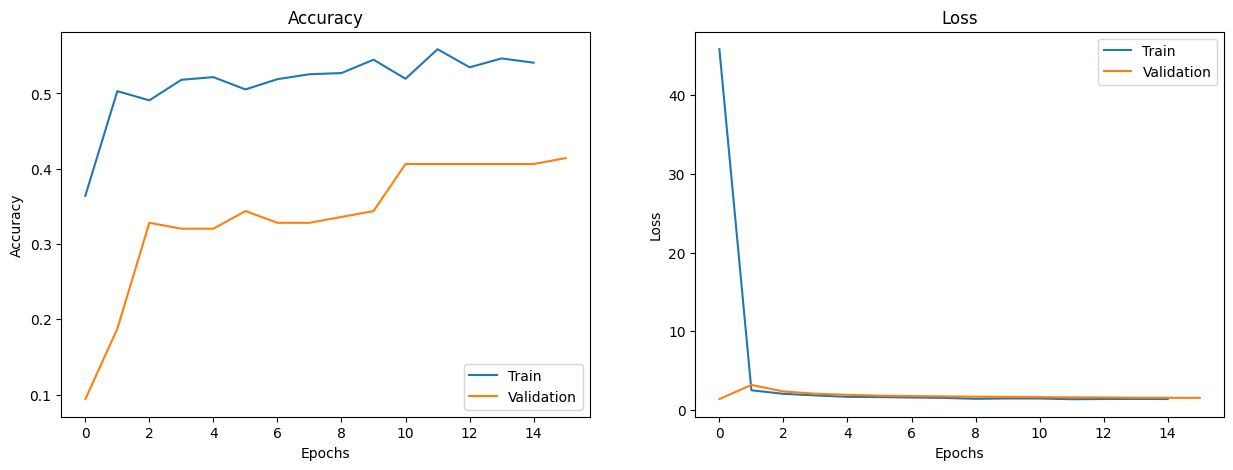

In [334]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.train_acc_plot)
plt.plot(model.val_acc_plot)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(model.train_loss_plot)
plt.plot(model.val_loss_plot)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

### Test one sample

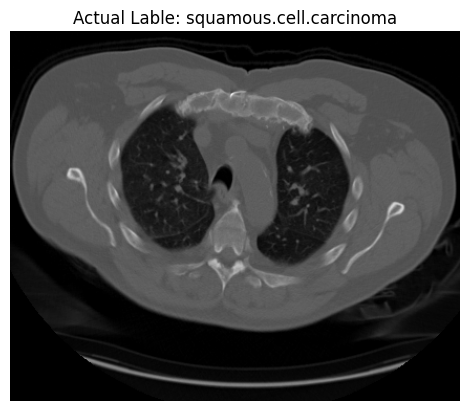

In [335]:
imeg_path = r"/kaggle/input/chest-ct-images/Data/test/squamous.cell.carcinoma/000117 (3).png"
# bcs the mode of image is RGBA but we need to convert it to RGB
test_image = Image.open(imeg_path).convert("RGB")
plt.title("Actual Lable: squamous.cell.carcinoma")
plt.axis("off")
plt.imshow(test_image)

In [336]:
new_test_image = val_transform(test_image)
model.eval()
with torch.no_grad():
  pred = model(new_test_image.unsqueeze(0))
  _, predicted = torch.max(pred, dim=1)
  print(f"Prediction: {categories[predicted.item()]}")

Prediction: adenocarcinoma


### Apply Pre-trained model

In [417]:
num_epochs = 15

In [428]:
class PreTrainedClassificationModel(pl.LightningModule):

  def __init__(self,num_classes):
    super(PreTrainedClassificationModel, self).__init__()
    self.num_classes = num_classes
    self.train_acc_plot = []
    self.train_loss_plot = []
    self.val_acc_plot = []
    self.val_loss_plot = []
    self.train_loss_outputs = []
    self.train_acc_outputs = []
    self.val_loss_outputs = []
    self.val_acc_outputs = []

    self.train_acc = Accuracy(task="multiclass", num_classes=4)
    self.val_acc = Accuracy(task="multiclass", num_classes=4)

    self.backbone = efficientnet_b0(pretrained=True)
    num_features = self.backbone.classifier[1].in_features
    self.backbone.classifier[1] = nn.Linear(num_features, self.num_classes)
    

  def forward(self, x):
    out = self.backbone(x)
    return out 

  def training_step(self, batch, batch_idx):
    images, labels = batch
    outputs = self(images)
    labels = labels.view(-1)
    loss = nn.functional.cross_entropy(outputs, labels)
    acc = self.train_acc(outputs, labels)
    self.train_acc_outputs.append(acc)
    self.train_loss_outputs.append(loss)
    return loss

  def validation_step(self, batch, batch_idx):
    images, labels = batch
    outputs = self(images)
    labels = labels.view(-1)
    loss = nn.functional.cross_entropy(outputs, labels)
    acc = self.val_acc(outputs, labels)
    self.val_acc_outputs.append(acc)
    self.val_loss_outputs.append(loss)
    return loss

  def on_train_epoch_end(self):
    avg_train_acc = torch.mean(torch.tensor(self.train_acc_outputs))
    avg_train_loss = torch.mean(torch.tensor(self.train_loss_outputs))
    self.log("train_acc", avg_train_acc, prog_bar=True)
    self.log("train_loss", avg_train_loss, prog_bar=True)

    self.train_acc_plot.append(avg_train_acc)
    self.train_loss_plot.append(avg_train_loss)

    print(f"train_acc: {avg_train_acc:.2f} / train_loss: {avg_train_loss:.2f}")
    print(50*"-")

    self.train_acc_outputs.clear()
    self.train_loss_outputs.clear()

  def on_validation_epoch_end(self):
    avg_val_acc = torch.mean(torch.tensor(self.val_acc_outputs))
    avg_val_loss = torch.mean(torch.tensor(self.val_loss_outputs))
    self.log("val_acc", avg_val_acc, prog_bar=True)
    self.log("val_loss", avg_val_loss, prog_bar=True)

    self.val_acc_plot.append(avg_val_acc)
    self.val_loss_plot.append(avg_val_loss)

    print(f"Epoch: {self.current_epoch+1}/{num_epochs}")
    print(f"val_acc: {avg_val_acc:.2f} / val_loss: {avg_val_loss:.2f}")

    self.val_acc_outputs.clear()
    self.val_loss_outputs.clear()

  def configure_optimizers(self):
    optimizer = torch.optim.Adagrad(self.parameters(), lr=learning_rate, lr_decay=0.9,weight_decay=0.001)
    return optimizer

  def train_dataloader(self):
    train_data = ImageFolder("/kaggle/input/chest-ct-images/Data/train", transform=train_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_dataloader

  def val_dataloader(self):
    val_data = ImageFolder("/kaggle/input/chest-ct-images/Data/valid", transform=val_transform)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    return val_dataloader



In [429]:
# early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=True,
    mode="min"
)

In [430]:
pre_trained_model = PreTrainedClassificationModel(num_classes=4)
trainer = pl.Trainer(max_epochs=num_epochs, log_every_n_steps=10, callbacks=[early_stop_callback])
trainer.fit(pre_trained_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch: 1/15
val_acc: 0.11 / val_loss: 1.41


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1/15
val_acc: 0.52 / val_loss: 1.36
train_acc: 0.60 / train_loss: 1.01
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2/15
val_acc: 0.62 / val_loss: 0.97
train_acc: 0.81 / train_loss: 0.53
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3/15
val_acc: 0.63 / val_loss: 0.85
train_acc: 0.86 / train_loss: 0.42
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4/15
val_acc: 0.76 / val_loss: 0.74
train_acc: 0.86 / train_loss: 0.37
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 5/15
val_acc: 0.78 / val_loss: 0.63
train_acc: 0.91 / train_loss: 0.32
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 6/15
val_acc: 0.82 / val_loss: 0.55
train_acc: 0.92 / train_loss: 0.28
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 7/15
val_acc: 0.85 / val_loss: 0.52
train_acc: 0.89 / train_loss: 0.30
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 8/15
val_acc: 0.80 / val_loss: 0.51
train_acc: 0.92 / train_loss: 0.28
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 9/15
val_acc: 0.80 / val_loss: 0.51
train_acc: 0.92 / train_loss: 0.27
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 10/15
val_acc: 0.80 / val_loss: 0.50
train_acc: 0.93 / train_loss: 0.25
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 11/15
val_acc: 0.80 / val_loss: 0.49
train_acc: 0.93 / train_loss: 0.26
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 12/15
val_acc: 0.80 / val_loss: 0.49
train_acc: 0.93 / train_loss: 0.25
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 13/15
val_acc: 0.81 / val_loss: 0.48
train_acc: 0.93 / train_loss: 0.24
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 14/15
val_acc: 0.81 / val_loss: 0.49
train_acc: 0.93 / train_loss: 0.23
--------------------------------------------------


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 15/15
val_acc: 0.81 / val_loss: 0.48
train_acc: 0.95 / train_loss: 0.21
--------------------------------------------------


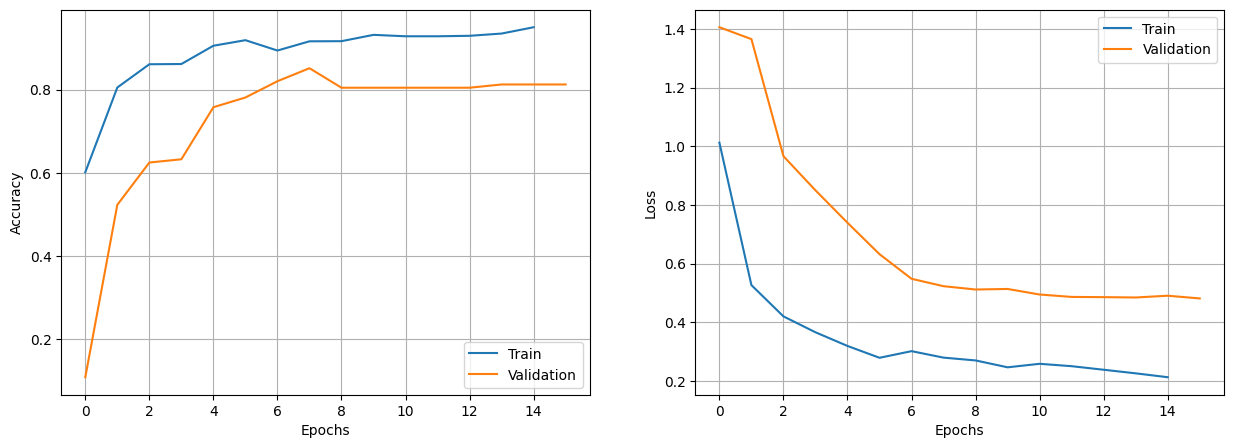

In [431]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(pre_trained_model.train_acc_plot)
plt.plot(pre_trained_model.val_acc_plot)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(visible=True)
plt.legend(["Train", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(pre_trained_model.train_loss_plot)
plt.plot(pre_trained_model.val_loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(visible=True)
plt.legend(["Train", "Validation"])
plt.show()

### Evaluation

In [432]:
test_data = ImageFolder("/kaggle/input/chest-ct-images/Data/test", transform=val_transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [433]:
predictions = []
labels = []
pre_trained_model.eval()
for batch_images, batch_labels in test_dataloader:
    
    with torch.no_grad():
       batch_images.to(device)
       batch_labels.to(device)
       outtputs = pre_trained_model(batch_images)
    _, pred = torch.max(outtputs, dim=1)
    predictions.append(pred.cpu().numpy())
    labels.append(batch_labels.cpu().numpy())
    

In [434]:
labels = np.concatenate(labels)
predictions = np.concatenate(predictions)

In [435]:
print(f"Accuracy: {accuracy_score(labels, predictions)}")
print(f"Precision: {precision_score(labels, predictions, average='macro')}")
print(f"Recall: {recall_score(labels, predictions, average='macro')}")

Accuracy: 0.8603174603174604
Precision: 0.8767280161203402
Recall: 0.8627450980392157


In [436]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       120
           1       0.82      0.78      0.80        51
           2       1.00      1.00      1.00        54
           3       0.88      0.77      0.82        90

    accuracy                           0.86       315
   macro avg       0.88      0.86      0.87       315
weighted avg       0.86      0.86      0.86       315



In [437]:
# save the model
torch.save(pre_trained_model, "model.pth")